# Imports

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit_algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from Graph7 import Graph7
import random
from InitPointGenerator import InitPointGenerator

In [3]:
import networkx.algorithms.approximation.maxcut as maxcut
from QAOACircuit import QAOACircuit
from QAOASimulation import QAOASimulation, SimType

# Build Random Graph

In [4]:
def build_graph_with_probability(num_vertices, probability):
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1")

    G = nx.Graph()
    G.add_nodes_from(range(num_vertices))   # Add vertices

    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if random.random() < probability:
                weight = random.uniform(0.1, 1.0)  # Assign random edge weight
                G.add_edge(i, j, weight=weight)  # Add edge with probability and weight

    return G

In [5]:
# Define a list of nx graphs of length 500
graphs = [build_graph_with_probability(7, 0.9) for _ in range(500)]



In [6]:
for graph in graphs:
    print(maxcut.one_exchange(graph))

(12, ({2, 5, 6}, {0, 1, 3, 4}))
(12, ({0, 1, 3}, {2, 4, 5, 6}))
(12, ({0, 2, 4}, {1, 3, 5, 6}))
(12, ({0, 1, 3}, {2, 4, 5, 6}))
(12, ({0, 2, 4}, {1, 3, 5, 6}))
(12, ({1, 4, 5}, {0, 2, 3, 6}))
(11, ({2, 4, 6}, {0, 1, 3, 5}))
(11, ({1, 2, 5}, {0, 3, 4, 6}))
(12, ({1, 5, 6}, {0, 2, 3, 4}))
(12, ({0, 2, 3}, {1, 4, 5, 6}))
(11, ({1, 5, 6}, {0, 2, 3, 4}))
(12, ({1, 2, 6}, {0, 3, 4, 5}))
(12, ({0, 4, 6}, {1, 2, 3, 5}))
(12, ({3, 5, 6}, {0, 1, 2, 4}))
(11, ({1, 4, 5}, {0, 2, 3, 6}))
(12, ({0, 3, 6}, {1, 2, 4, 5}))
(11, ({2, 4, 5}, {0, 1, 3, 6}))
(12, ({0, 1, 6}, {2, 3, 4, 5}))
(12, ({2, 3, 5}, {0, 1, 4, 6}))
(12, ({1, 2, 5}, {0, 3, 4, 6}))
(12, ({1, 4, 6}, {0, 2, 3, 5}))
(12, ({2, 3, 6}, {0, 1, 4, 5}))
(12, ({0, 1, 4}, {2, 3, 5, 6}))
(12, ({0, 2, 5}, {1, 3, 4, 6}))
(12, ({0, 2, 5}, {1, 3, 4, 6}))
(12, ({3, 4, 5}, {0, 1, 2, 6}))
(12, ({0, 2, 3}, {1, 4, 5, 6}))
(12, ({1, 4, 6}, {0, 2, 3, 5}))
(12, ({1, 2, 3}, {0, 4, 5, 6}))
(12, ({0, 1, 6}, {2, 3, 4, 5}))
(12, ({0, 3, 5}, {1, 2, 4, 6}))
(12, ({2

# Attempt at calling simulator object (STATE_VECTOR)

In [7]:
graph_objs = [Graph7(graph, 'Graph {}'.format(i)) for i, graph in enumerate(graphs)]
sim_sv = QAOASimulation(SimType.STATE_VECTOR, graph_objs[0])

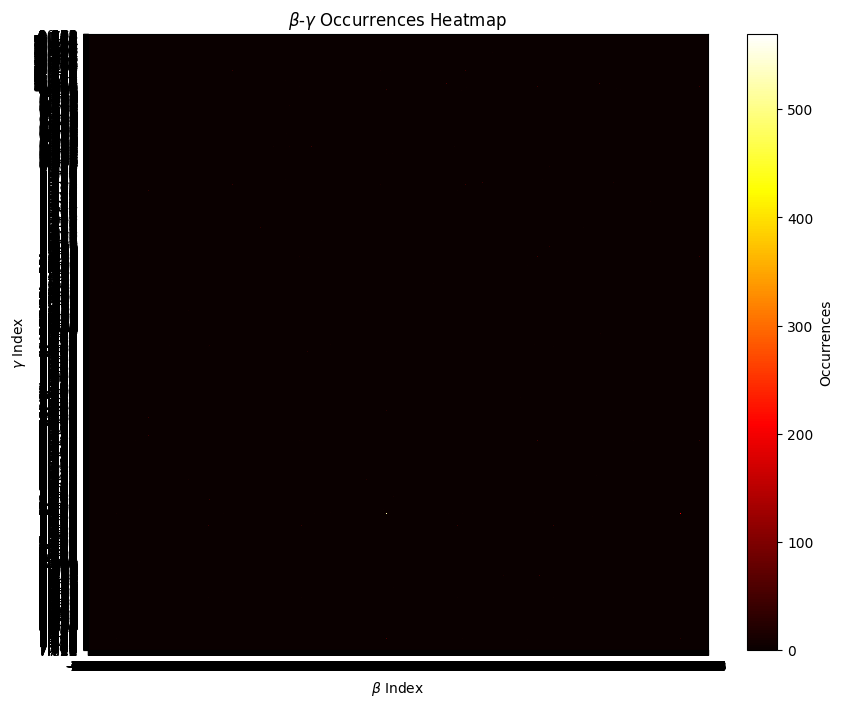

In [12]:
import numpy as np
import time
import pickle
import os.path
from QAOASimulation import QAOASimulation, SimType
from InitPointGenerator import InitPointGenerator
from HeatMap import HeatMap
import multiprocessing

# Define the number of processes
num_processes = multiprocessing.cpu_count()

p = 7
n = 50

graph=graph_objs[0]

if os.path.exists('optimal_params_array.pkl') and os.path.exists('optimal_counts_list.pkl') and os.path.exists('heatmap_data_list.pkl'):
    # Load existing data from files
    with open('optimal_params_array.pkl', 'rb') as file:
        optimal_params_array = pickle.load(file)
    with open('optimal_counts_list.pkl', 'rb') as file:
        optimal_counts_list = pickle.load(file)
    with open('heatmap_data_list.pkl', 'rb') as file:
        heatmap_data_list = pickle.load(file)

else:
    # Initialize InitPointGenerator
    init_point_generator = InitPointGenerator(p, n)
    init_points = init_point_generator.generate_and_save_init_points()

    # Create an instance of HeatMap
    heatmap = HeatMap(p)

    # Use multiprocessing to parallelize the optimization process
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(sim_sv.optimize, init_points)

    # Extract the results from the multiprocessing results
    optimal_params_array = np.zeros((len(results), 2*p))
    optimal_counts_list = []
    heatmap_data_list = []


    for i, (opt_res, heatmap_data) in enumerate(results):
        optimal_params_array[i, :] = opt_res.x
        opt_res_counts = sim_sv.run_circuit_optimal_params(opt_res, graph)
        optimal_counts_list.append(opt_res_counts)
        heatmap_data_list.append(heatmap_data)

    # Save the results to files
    with open('optimal_params_array.pkl', 'wb') as file:
        pickle.dump(optimal_params_array, file)
    with open('optimal_counts_list.pkl', 'wb') as file:
        pickle.dump(optimal_counts_list, file)
    with open('heatmap_data_list.pkl', 'wb') as file:
        pickle.dump(heatmap_data_list, file)

# Plot the heatmap
HeatMap.plot_heatmap(heatmap_data_list,2)


In [ ]:
import os

# Replace 'G' with your graph
graph = graph_objs[0]

if not os.path.exists('best_cuts_and_solutions.pkl'):
    # Separate loop for calculating best cut and best solution
    best_cuts_and_solutions = []
    for i in range(num_init_points):
        opt_res_counts = optimal_counts_list[i]
        best_cut, best_solution = sim_sv.best_solution(graph, opt_res_counts)
        best_cuts_and_solutions.append((best_cut, best_solution))

    # Store the best cuts and solutions if the file doesn't exist
    with open('best_cuts_and_solutions.pkl', 'wb') as file:
        pickle.dump(best_cuts_and_solutions, file)
else:
    # Load the best cuts and solutions from the file
    with open('best_cuts_and_solutions.pkl', 'rb') as file:
        best_cuts_and_solutions = pickle.load(file)

In [ ]:
prob_values, optimal_beta_values, optimal_gamma_values = sim_sv.analyze_results(optimal_counts_list, optimal_params_array)
sim_sv.plot_results(prob_values, optimal_beta_values, optimal_gamma_values)


In [ ]:
# from IPython.display import display

# # Build for loop on enumerate of graphs and index
# qaoas = [QAOACircuit(graph, [np.pi/3], [np.pi/2]) for graph in graphs]
# for qaoa in qaoas:
#     display(qaoa.draw_circuit())

In [ ]:
# color the graph nodes by part
G = graph_objs[0].graph
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
cut_edges = [(u, v) for u, v in G.edges() if ((best_solution[u] == '0' and best_solution[v] != '0') or (best_solution[u] != '0' and best_solution[v] == '0'))]

cut_edge_color = 'red'
non_cut_edge_color = 'black'
for edge in G.edges():
    if edge in cut_edges:
        G[edge[0]][edge[1]]['color'] = cut_edge_color
    else:
        G[edge[0]][edge[1]]['color'] = non_cut_edge_color

edge_colors = [G[edge[0]][edge[1]]['color'] for edge in G.edges()]

nx.draw(G, node_color = colors, with_labels=True, font_weight='bold', edge_color=edge_colors)
plt.show()

# Attempt at calling simulator object (NOISY_SIMULATOR)

In [ ]:
sim_n = QAOASimulation(SimType.NOISY_SIMULATOR)

In [ ]:
opt_res = sim_n.get_opt_params(graph_objs[0])
opt_res_counts = sim_n.run_circuit_optimal_params(opt_res, graph_objs[0])

In [ ]:
best_cut, best_solution = sim_n.best_solution(graph_objs[0], opt_res_counts)

In [ ]:
G = graph_objs[0].graph
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
cut_edges = [(u, v) for u, v in G.edges() if ((best_solution[u] == '0' and best_solution[v] != '0') or (best_solution[u] != '0' and best_solution[v] == '0'))]

cut_edge_color = 'red'
non_cut_edge_color = 'black'
for edge in G.edges():
    if edge in cut_edges:
        G[edge[0]][edge[1]]['color'] = cut_edge_color
    else:
        G[edge[0]][edge[1]]['color'] = non_cut_edge_color

edge_colors = [G[edge[0]][edge[1]]['color'] for edge in G.edges()]

nx.draw(G, node_color = colors, with_labels=True, font_weight='bold', edge_color=edge_colors)
plt.show()